In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt

from baum_welch_jax.algorithms import baum_welch, generate_sequence
from baum_welch_jax.models import HiddenMarkovParameters



jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

In [2]:
from matplotlib.figure import Figure
import numpy as np

def plot_hmm_params(hmm: HiddenMarkovParameters) -> tuple[Figure, np.ndarray]:
    n, m = hmm.O.shape
    fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
    fig.set_size_inches(5,2)

    if hmm.is_log:
        hmm = hmm.to_prob()

    ax[0].imshow(hmm.T)
    ax[0].set_title("T")
    ax[1].imshow(hmm.O)
    ax[1].set_title("O")
    ax[2].imshow(hmm.mu[:,None])
    ax[2].set_title(r"$\mu$")
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    return fig, ax

In [3]:
T = jnp.array(
    [
        [0.9, 0.1], 
        [0.1,0.9]
    ]
)
O = jnp.eye(2)
mu = jnp.array([0.0, 1.0])
hmm = HiddenMarkovParameters(T, O, mu)

init_guess = HiddenMarkovParameters(
    jnp.ones((2,2)) / 2, 
    jnp.ones((2,2)) / 2, 
    jnp.array([0.2,0.8]))

states, obs = generate_sequence(key(0), hmm, 500)
result = baum_welch(obs, init_guess, max_iter=5000, tol=1e-6, mode='log')

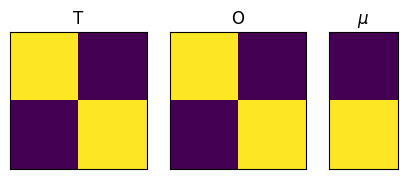

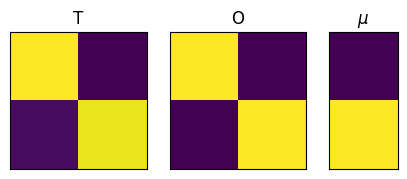

Likelihood is nondecreasing: True


In [4]:


fig, ax = plot_hmm_params(hmm)
plt.show()

fig, ax = plot_hmm_params(result.params)
plt.show()

print('Likelihood is nondecreasing:', bool(jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0)))


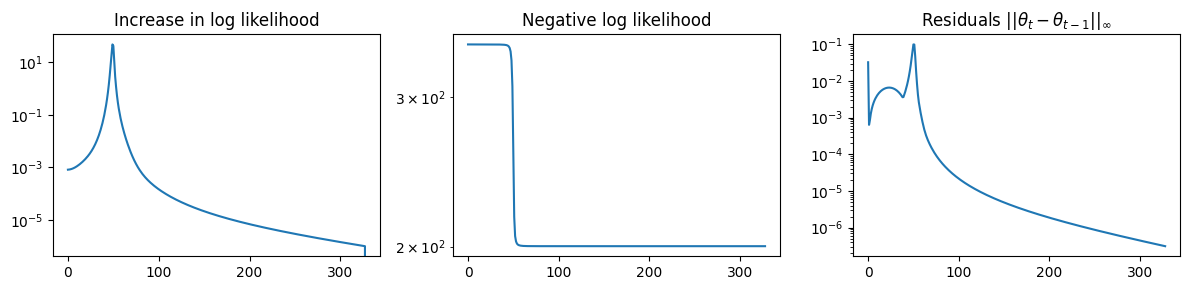

329 False


HiddenMarkovParameters(T=Array([[0.872, 0.128],
       [0.15 , 0.85 ]], dtype=float64), O=Array([[1.000e+00, 2.557e-05],
       [2.034e-34, 1.000e+00]], dtype=float64), mu=Array([0., 1.], dtype=float64), is_log=False)

In [5]:

def plot_inference_statistics(result):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12,3)
    ax[0].semilogy(jnp.diff(result.log_likelihoods))
    ax[0].set_title('Increase in log likelihood')
    ax[1].semilogy(jnp.abs(result.log_likelihoods[:result.iterations]))
    ax[1].set_title('Negative log likelihood')
    ax[2].semilogy(result.residuals)
    ax[2].set_title('Residuals $||\\theta_t - \\theta_{{t-1}}||_\\infty$')
    fig.tight_layout()
    return fig, ax

plot_inference_statistics(result)
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

In [6]:
seed = 2345
n = 4 # Number of states
m = 3 # Number of observations
# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.95 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.05 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jnp.zeros((n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
O = O.at[0, 0].set(1.0)
for s in range(n):
    O = O.at[s].set(jnp.exp(- ((jnp.arange(m) - (s*m) / n)**2)/(s + 1)))
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

mu_seq = jnp.concat(jnp.eye(n)[None, ...].repeat(100 // n, axis=0))

hmm = HiddenMarkovParameters(T, O, mu)
hmm_seq = HiddenMarkovParameters(T, O, mu_seq)

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])


T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


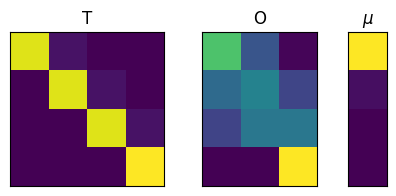

In [7]:
fig, ax = plot_hmm_params(hmm)
plt.show()

In [8]:
from baum_welch_jax.algorithms import generate_sequence

n_sequences = 100
len_sequence = 100
rng_key, *sequence_keys = split(key(123), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, hmm, len_sequence))

states, observations = generate_sequence(sequence_keys[0], hmm_seq, len_sequence)# jax.vmap(generate)(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (100, 100)


In [9]:
key_T, key_O, key_mu = split(key(0), 3)

_T = uniform(key_T, T.shape)
_O = uniform(key_O, O.shape)
_mu = uniform(key_mu, mu.shape)


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)


init_guess = HiddenMarkovParameters(_T, _O, _mu)
result = baum_welch(observations, init_guess, max_iter=5000, tol=1e-10, mode='log')

print(result.params.mu[0])

-36726.147524977794


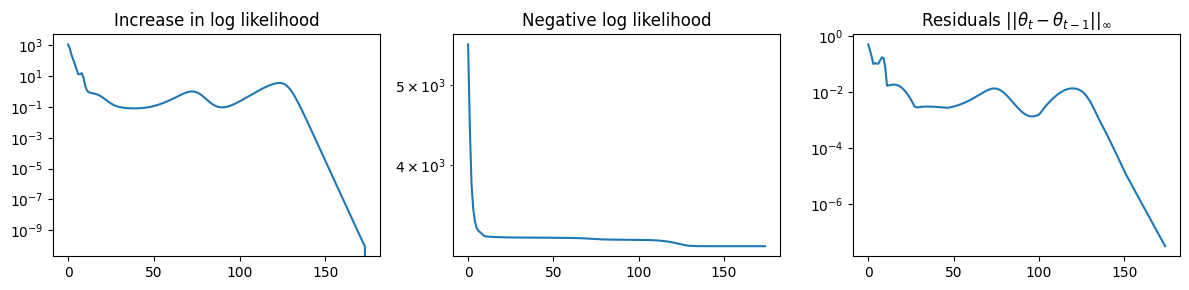

175 Terminated: False


HiddenMarkovParameters(T=Array([[5.210e-001, 4.180e-123, 5.228e-186, 4.790e-001],
       [1.738e-002, 9.582e-001, 6.403e-003, 1.799e-002],
       [2.640e-003, 6.771e-002, 8.939e-001, 3.578e-002],
       [5.330e-001, 1.292e-117, 4.577e-178, 4.670e-001]], dtype=float64), O=Array([[8.664e-220, 6.572e-159, 1.000e+000],
       [2.028e-001, 4.081e-001, 3.891e-001],
       [5.205e-001, 3.544e-001, 1.251e-001],
       [6.165e-212, 9.698e-156, 1.000e+000]], dtype=float64), mu=Array([0.000e+000, 2.985e-134, 1.000e+000, 0.000e+000], dtype=float64), is_log=False)

In [10]:
plot_inference_statistics(result)
plt.show()

print(result.iterations, 'Terminated:', result.terminated)
result.params.to_prob()

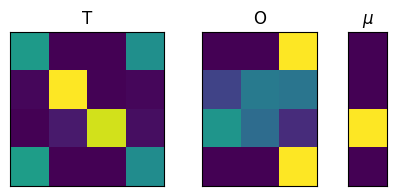

Likelihood is nondecreasing: True


In [11]:
fig, ax = plot_hmm_params(result.params)
plt.show()

print('Likelihood is nondecreasing:', bool(jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0)))

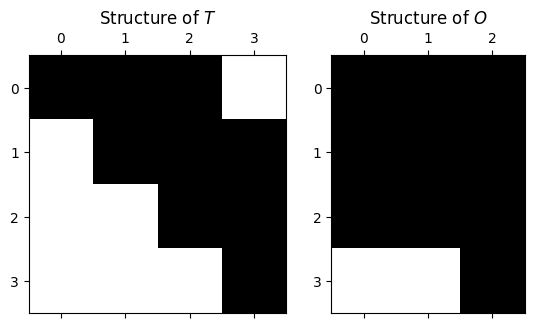

In [12]:
T_structure = jnp.tril(jnp.triu(jnp.ones_like(T, dtype=jnp.float64)), 2)
O_structure = jnp.ones_like(O, dtype=jnp.float64)
O_structure = O_structure.at[n-1, :m-1].set(0)

fig, ax = plt.subplots(1,2, width_ratios=(n, m))
ax[0].spy(T_structure)
ax[0].set_title("Structure of $T$")
ax[1].spy(O_structure)
ax[1].set_title("Structure of $O$")
plt.show()

In [13]:
key_T, key_O, key_mu = split(key(120), 3)

_T = uniform(key_T, T.shape) * T_structure + jnp.eye(n)
_O = uniform(key_O, O.shape) * O_structure + jnp.eye(n, m)
_mu = uniform(key_mu, mu.shape) + jnp.array([k == 0 for k in range(n)])


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)
init_guess = HiddenMarkovParameters(_T, _O, _mu)



In [14]:
result = baum_welch(observations, init_guess, max_iter=1000, tol=1e-10, mode='log')

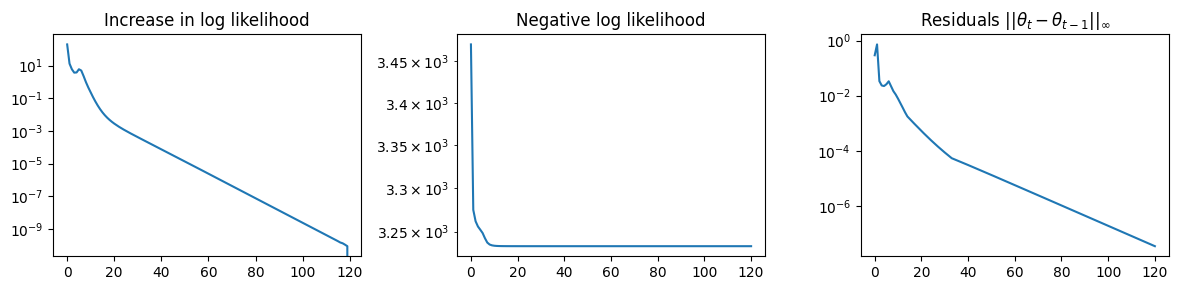

121 False


HiddenMarkovParameters(T=Array([[0.86 , 0.026, 0.113, 0.   ],
       [0.   , 0.964, 0.03 , 0.005],
       [0.   , 0.   , 0.937, 0.063],
       [0.   , 0.   , 0.   , 1.   ]], dtype=float64), O=Array([[0.566, 0.311, 0.123],
       [0.358, 0.448, 0.194],
       [0.189, 0.388, 0.422],
       [0.   , 0.   , 1.   ]], dtype=float64), mu=Array([1.000e+000, 2.600e-012, 5.337e-125, 0.000e+000], dtype=float64), is_log=False)

In [15]:
plot_inference_statistics(result)
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

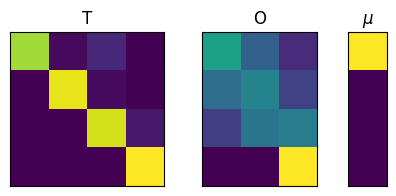

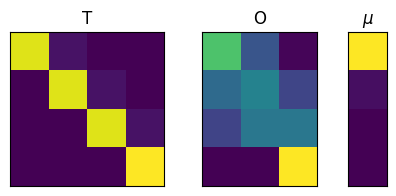

In [16]:
fig, ax = plot_hmm_params(result.params)
plt.show()

fig, ax = plot_hmm_params(hmm)
plt.show()


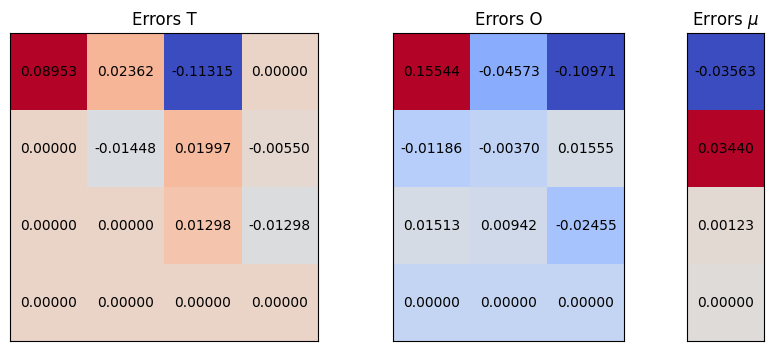

In [17]:
import numpy as np
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(10,4)

res_hmm = result.params.to_prob()

errors = [
    T - res_hmm.T,
    O - res_hmm.O,
    mu[:,None] - res_hmm.mu[:,None]
]

labels = [
    'T',
    'O',
    '$\\mu$'
]

for k, (err_mat, label) in enumerate(zip(errors, labels)):
    ax[k].matshow(err_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(err_mat):
        ax[k].text(j, i, '{:0.5f}'.format(z), ha='center', va='center')
    ax[k].set_title(f"Errors {label}")
    ax[k].set_xticks([])
    ax[k].set_yticks([])
plt.show()

In [18]:
import matplotlib.pyplot as plt
from jax import lax

def plot_stats(states, observations):
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(16,4)

    ax[0].set_title("Mean state evolution over time")
    ax[0].plot(jnp.mean(states, axis=0))
    ax[0].grid()
    ax[0].set_xlabel("Time step")
    ax[0].set_ylabel("State")

    
    ax[1].set_title("Arrival distribution in final state")
    ax[1].plot(jnp.mean(states == jnp.max(states), axis=0))
    ax[1].set_xlabel("Sequence length")
    ax[1].set_ylabel("Probability of reaching final state before $t$")
    ax[1].grid()

    obs_distribution = lax.map(lambda o: jnp.count_nonzero(observations == o, axis=0), jnp.arange(jnp.max(observations) + 1)) / observations.shape[0]
    for k, obs_prob in enumerate(obs_distribution):
        ax[2].plot(obs_prob, label=f"$o^{k}$")
        # ax[2].fill_between(range(len(obs_prob)), obs_prob - 0.05, obs_prob + 0.05, label=f"$o^{k}$", alpha=0.25)
    ax[2].set_title("Observation distribution over time")
    ax[2].grid()
    ax[2].legend()
    ax[2].set_xlabel("Time step")
    ax[2].set_ylabel("$p(o_t)$")

    state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(jnp.max(states) + 1)) / states.shape[0]
    for k, state_prob in enumerate(state_distribution):
        ax[3].plot(state_prob, label=f"$s^{k}$")

    ax[3].set_title("State distribution over time")
    ax[3].set_xlabel("t")
    ax[3].set_ylabel("$p(s_t)$")
    ax[3].grid()
    ax[3].legend()

    plt.tight_layout()
    plt.show()



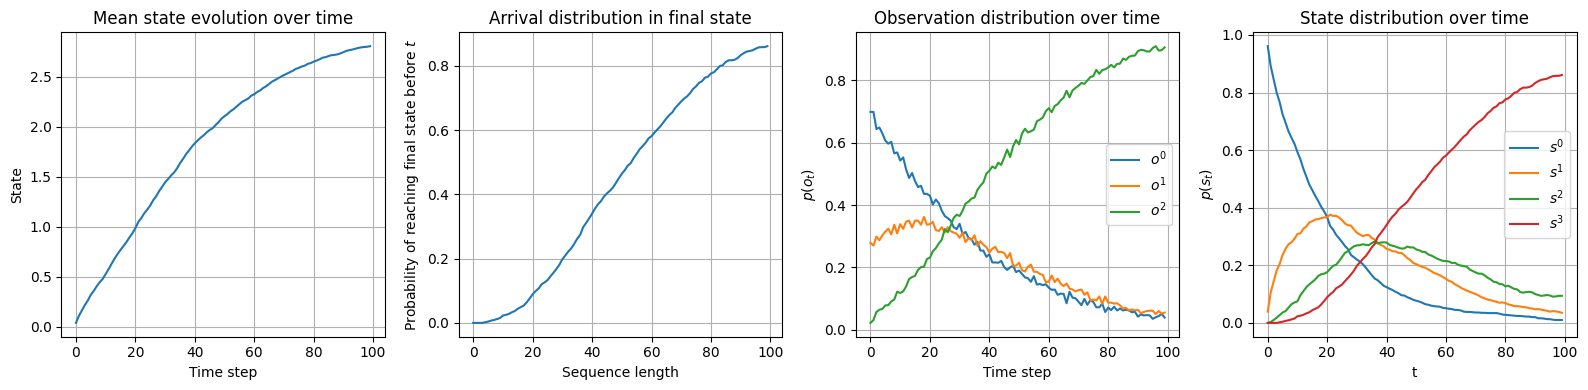

In [19]:
n_sequences = 1000
len_sequence = 100
seed = 512

rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, hmm, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

plot_stats(states, observations)

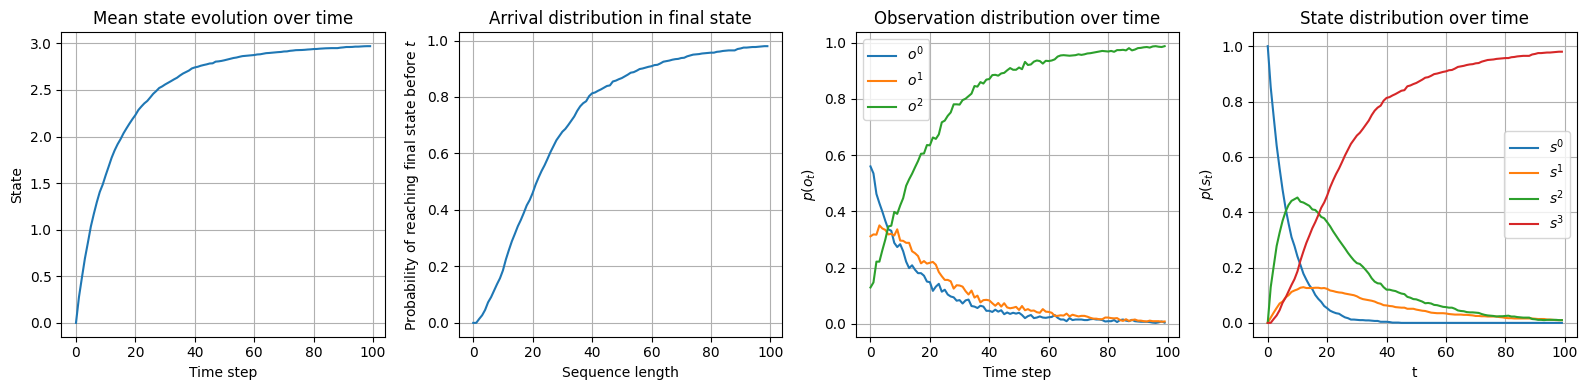

In [20]:
generate = jax.jit(lambda _key: generate_sequence(_key, result.params, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

plot_stats(states, observations)

In [21]:

T_TEST_STRUCTURED = jnp.array([
	[0.95, 0.05, 0.0, 0.0],
	[0.0, 0.95, 0.05, 0.0],
	[0.0, 0.0, 0.95, 0.05],
	[0.0, 0.0, 0.0, 1.0]
], jnp.float32)

MU_TEST_STRUCTURED = jnp.array(
    [0.964369788973432, 0.03440292143612942, 0.001227289590438528, 0.0], jnp.float32)

O_TEST_STRUCTURED = jnp.array([
	[0.7213991842739687, 0.2653879287722419, 0.013212886953789416],
	[0.3459541948223698, 0.44421397916166544, 0.20983182601596484],
	[0.2042705586529167, 0.39786472067354167, 0.39786472067354167],
	[0.0, 0.0, 1.0]
], jnp.float32)

HMM_TEST_STRUCTURED = HiddenMarkovParameters(
    T=T_TEST_STRUCTURED, O=O_TEST_STRUCTURED, mu=MU_TEST_STRUCTURED)

mode = 'log'

n_seq = 150
len_seq = 100
n, m = O_TEST_STRUCTURED.shape
key_T, key_O, key_mu, *seq_keys = split(key(345), 3 + n_seq)

# Prepare structured HMM parameters and sequences
T_structure = jnp.tril(jnp.triu(jnp.ones_like(T_TEST_STRUCTURED, dtype=jnp.float64)), 2)
O_structure = jnp.ones_like(O_TEST_STRUCTURED, dtype=jnp.float64)
O_structure = O_structure.at[n-1, :m-1].set(0)

_, obs = jax.vmap(
    lambda _k: generate_sequence(_k, HMM_TEST_STRUCTURED.astype(jnp.float64), len_seq)
    )(jnp.array(seq_keys))

# Set up the structured initialization of the HMM parameters
# with some bias towards the true parameters
_T = uniform(key_T, (n,n)) * T_structure
_O = uniform(key_O, (n,m)) * O_structure
_mu = uniform(key_mu, n)

_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)
init_guess = HiddenMarkovParameters(_T, _O, _mu)


# Run the algorithm
result = baum_welch(obs, init_guess.astype(jnp.float64), max_iter=500, tol=1e-12, check_ascent=True, mode=mode)
res_params = result.params.to_prob() if mode == 'log' else result.params

# Test if parameters were learned correctly 
assert not result.terminated
if jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0):
	print(f'{result.iterations} iterations performed until monotonicity violated')

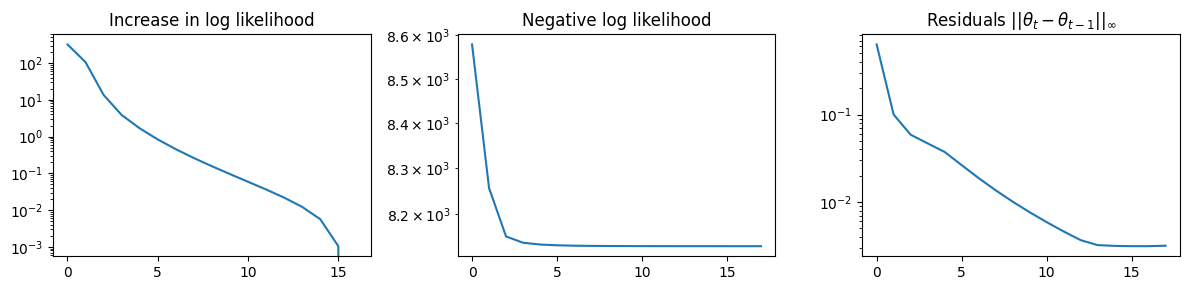

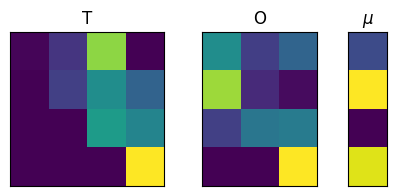

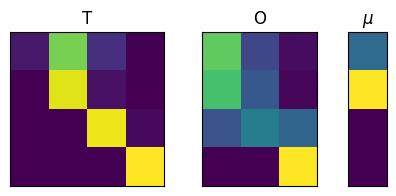

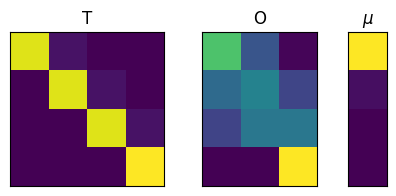

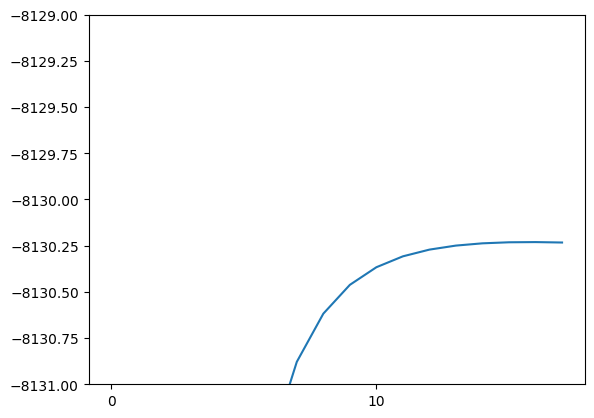

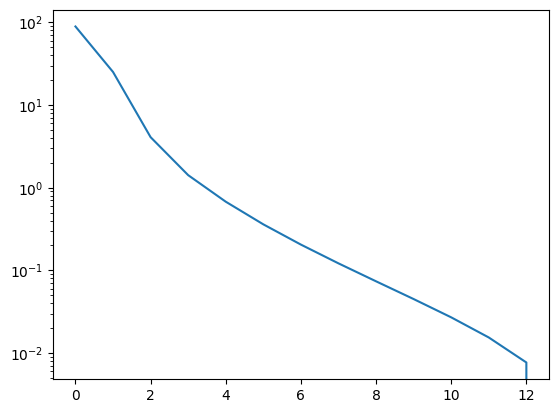

In [22]:
plot_inference_statistics(result)
plt.show()

plot_hmm_params(init_guess)
plt.show()

plot_hmm_params(res_params)
plt.show()

plot_hmm_params(HMM_TEST_STRUCTURED)
plt.show()

plt.plot(range(result.iterations), result.log_likelihoods[:result.iterations])
plt.xticks(range(0, result.iterations, 10))
plt.ylim(-8131, -8129)
plt.show()

plt.semilogy(jnp.diff(jnp.convolve(result.log_likelihoods, jnp.ones(5) / 5, mode='valid')))
plt.show()
